In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import math
import pickle

import geopandas as gpd
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
from shapely.geometry import Polygon, box
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Set up the Earth Engine
import ee

service_account = 'ping-gee@ee-supercharge-naturesnotebook.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, 'ee-supercharge-naturesnotebook-5b165b3dae23.json')
ee.Initialize(credentials)

In [4]:
# Constants
RESOLUTION = 375                # meters
HALF_RESOLUTION = 375 / 2       # meters
METERS_PER_DEGREE = 111139      # degrees of latitude, or longitude at the equator

DATA_ARRAY_WIDTH = 128          # number of RESOLUTION-meter cells 
DATA_ARRAY_HEIGHT = 128         # number of RESOLUTION-meter cells

WIDTH_LIMIT_METERS = RESOLUTION * DATA_ARRAY_WIDTH
HEIGHT_LIMIT_METERS = RESOLUTION * DATA_ARRAY_HEIGHT

DATA_DIR = "./data"
FILTERED_DATA_PATH = "./data_filtered/filtered_data_{0}.pkl"

# Observation time of specific observation as YYYY-MM-DD HH:MM:SS
VIIRS_DATETIME_FIELD = "date_time"

REPROJECTION = "EPSG:4326"

FIELD_TO_GEE_PATH = {
    "elevation": "CGIAR/SRTM90_V4",                                     # SRTM Digital Elevation Data Version 4
    "climate": "ECMWF/ERA5/DAILY",                                      # ERA5 Daily Aggregates
    "vegetation": "MODIS/006/MOD13A2",                                  # MOD13A2.061 Terra Vegetation Indices
    "population_density": "CIESIN/GPWv411/GPW_Population_Density",      # Gridded Population of the World Version 4.11
    "water_index": "LANDSAT/LC08/C01/T1_32DAY_NDWI",                    # Landsat 8 Collection 1 Tier 1 32-Day NDWI Composite
    "burn_severity": "USFS/GTAC/MTBS/annual_burn_severity_mosaics/v1",  # MTBS Burn Severity Images
    "burn_area": "ESA/CCI/FireCCI/5_1",                                 # MODIS Burned Area Pixel Product Version 5.1
    "land_cover": "USGS/NLCD_RELEASES/2020_REL/NALCMS",                 # Land Cover of North America at 30 Meters, 2020
    "roads": "TIGER/2016/Roads",                                        # TIGER: US Census Roads 
}

In [5]:
YEAR = 2015
filtered_viirs_data = pickle.load(open(FILTERED_DATA_PATH.format(YEAR), 'rb'))
perimeter_data = gpd.read_file(os.path.join(DATA_DIR, "perimeters", f"US_HIST_FIRE_PERIM_{YEAR}_DD83.shp"), engine="pyogrio")

In [6]:
unique_fire_to_perimeter = perimeter_data.groupby("uniquefire")['geometry'].unique().to_dict()

In [8]:
def get_bounding_box_extents_in_meters(geometry):
    '''
    Returns the width and height in meters of the bounding box that contains the provided geometry. Converts
    from a difference in degrees longitude to meters at the widest point of the bounding box (i.e. closest
    to the equator)
    '''

    # For access to utility methods, create a single-entry dataframe with the specified geometry
    geo_df = gpd.GeoDataFrame(geometry=[geometry])
    min_lon, min_lat, max_lon, max_lat = geo_df.geometry.total_bounds

    height_in_degrees = max_lat - min_lat
    width_in_degrees = max_lon - min_lon

    # Determine the latitude at which the box is widest
    if math.copysign(1, min_lat) == math.copysign(1, max_lat):
        lat_at_widest = min(abs(min_lat), abs(max_lat))
    else:
        lat_at_widest = 0

    # Calculate height and width in meters, assuming the Earth is rouhgly spherical
    height_in_meters = METERS_PER_DEGREE * height_in_degrees
    width_in_meters = METERS_PER_DEGREE * width_in_degrees * np.cos(np.radians(lat_at_widest))

    return height_in_meters, width_in_meters

In [9]:
# Filter out all fires whose perimeters are wider or taller than our specified array size

# Compute the height and width of each fire perimeter bounding box in METERS
heights, widths = [], []
filtered_idxs_and_groups = []
for perimeter_index, group in filtered_viirs_data.groupby("index_right"):

    height, width = get_bounding_box_extents_in_meters(perimeter_data.loc[perimeter_index]['geometry'])

    heights.append(height)
    widths.append(width)

    if height < HEIGHT_LIMIT_METERS and width < WIDTH_LIMIT_METERS:
        filtered_idxs_and_groups.append((perimeter_index, group))


In [11]:
prop = len(filtered_idxs_and_groups) / len(heights)
print(f"Given a width limit of {WIDTH_LIMIT_METERS} meters and a height limit of {HEIGHT_LIMIT_METERS} meters, we keep {'%.2f' % (100 * prop)}% of perimeters")

Given a width limit of 48000 meters and a height limit of 48000 meters, we keep 98.45% of perimeters


Min = 123.31961212508355, Max = 87681.23735684942, 90th, 95th, 99th = 19957.83944954492, 28735.520850265697, 52844.94652646135


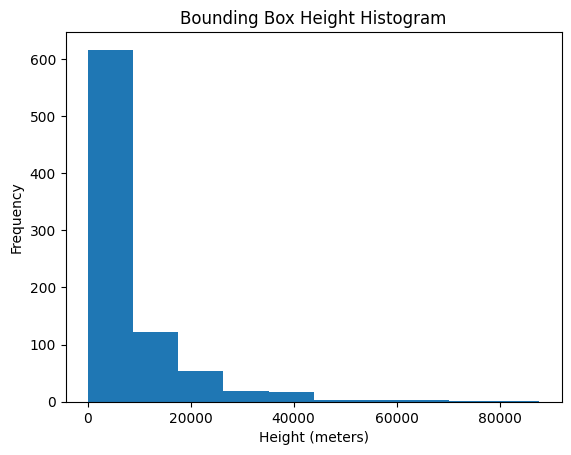

In [12]:
plt.hist(heights)
plt.xlabel("Height (meters)")
plt.ylabel("Frequency")
plt.title("Bounding Box Height Histogram")

print(f"Min = {np.min(heights)}, Max = {np.max(heights)}, 90th, 95th, 99th = {np.percentile(heights, 90)}, {np.percentile(heights, 95)}, {np.percentile(heights, 99)}")

Min = 204.89655008146156, Max = 117045.23975375449, 90th, 95th, 99th = 20096.91281268619, 29635.99019782524, 45487.90971063


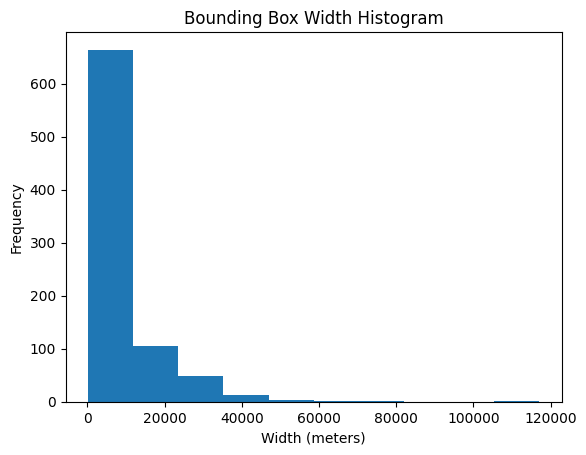

In [13]:
plt.hist(widths)
plt.xlabel("Width (meters)")
plt.ylabel("Frequency")
plt.title("Bounding Box Width Histogram")

print(f"Min = {np.min(widths)}, Max = {np.max(widths)}, 90th, 95th, 99th = {np.percentile(widths, 90)}, {np.percentile(widths, 95)}, {np.percentile(widths, 99)}")

In [14]:
def convert_gee_region_info_to_lookup(gee_region_info, data_key):
    lookup = {}

    # First row is headers
    headers = gee_region_info[0]

    for row in gee_region_info[1:]:
        info = dict(zip(headers, row))

        lookup[(info['latitude'], info['longitude'])] = info[data_key]

    return lookup

def haversine(coord1, coord2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

def build_kd_tree(geo_dict):
    points = list(geo_dict.keys())
    return KDTree(points), points

def find_value_at_closest_point(kd_tree, points, observation_lat_lon, geo_dict):
    dist, index = kd_tree.query(observation_lat_lon)
    closest_point = points[index]
    # print(closest_point)
    return geo_dict[closest_point]

In [15]:
# Iterative through each of the kept perimeters / VIIRS groups
excs = 0
for perimiter_index, group in tqdm(filtered_idxs_and_groups, total=len(filtered_idxs_and_groups)):
    try:
        # We need to extract the perimiter geometry data from the index because the 'geometry' field in group holds only
        # the point's geometry
        bounding_perimeter = gpd.GeoDataFrame(geometry=[perimeter_data.loc[perimiter_index]['geometry']]).geometry.total_bounds # min-x, min-y, max-x, max-y
        center_point = (bounding_perimeter[0] + (bounding_perimeter[2] - bounding_perimeter[0]) / 2, 
                        bounding_perimeter[1] + (bounding_perimeter[3] - bounding_perimeter[1]) / 2)

        # Given the center point (lat, lon), we need to determine the (lat, lon) of the extended bounding box (i.e. the box
        # that surrounds the largest fire computed above). We do this by moving the calculated number of *meters* in every
        # direction from the center point and computing the resulting (lat, lon) points
        max_lat = center_point[1] + (HEIGHT_LIMIT_METERS / 2) / METERS_PER_DEGREE
        min_lat = center_point[1] - (HEIGHT_LIMIT_METERS / 2) / METERS_PER_DEGREE

        # Determine the latitude at which the box is widest
        if math.copysign(1, min_lat) == math.copysign(1, max_lat):
            lat_at_widest = min(abs(min_lat), abs(max_lat))
        else:
            lat_at_widest = 0

        min_lon = center_point[0] - (WIDTH_LIMIT_METERS / 2) / (METERS_PER_DEGREE * np.cos(np.radians(lat_at_widest)))
        max_lon = center_point[1] + (WIDTH_LIMIT_METERS / 2) / (METERS_PER_DEGREE * np.cos(np.radians(lat_at_widest)))

        # Use extended bounding box as the region to restrict our GEE lookups
        extended_bounding_box = (min_lon, min_lat, max_lon, max_lat)
        gee_region = ee.Geometry.Rectangle(extended_bounding_box)

        # Compute the temporal range of all VIIRS observations associated with this perimeter
        # TODO: need to account for the observation frequency of the data, and ensure that for each data point
        # we have a corresponding observation from *before* that point's collection
        temporal_range = (group[VIIRS_DATETIME_FIELD].min(), group[VIIRS_DATETIME_FIELD].max())

        vegetation = (ee.ImageCollection(FIELD_TO_GEE_PATH['vegetation'])
            .filterDate(*temporal_range)
            .select('NDVI')
        )

        vegetation = vegetation.getRegion(gee_region, scale=1000)
        vegetation_lookup = convert_gee_region_info_to_lookup(vegetation.getInfo(), 'NDVI') # TODO: does not account for observations on multiple days
        vegetation_kd_tree, points = build_kd_tree(vegetation_lookup)

        # Determine the step size in latitude and longitude
        step_size_lat = (max_lat - min_lat) / DATA_ARRAY_HEIGHT
        step_size_lon = (max_lon - min_lon) / DATA_ARRAY_WIDTH

        # Instantiate the empty array that will hold the GEE data for each grid cell
        data_array = np.empty([DATA_ARRAY_HEIGHT, DATA_ARRAY_HEIGHT])

        for i, latitude in enumerate(np.arange(min_lat, max_lat, step_size_lat)):
            for j, longitude in enumerate(np.arange(min_lon, max_lon, step_size_lon)):
                value_at_closest_point = find_value_at_closest_point(vegetation_kd_tree, points, (latitude, longitude), vegetation_lookup)
                data_array[i, j] = value_at_closest_point

        print(data_array.shape)



    except Exception as e:
        excs += 1
        print(f"[{excs}] Exception: {e}")

    # break

  0%|          | 0/826 [00:00<?, ?it/s]

  0%|          | 1/826 [00:15<3:30:22, 15.30s/it]

(128, 128)


  0%|          | 2/826 [00:31<3:36:03, 15.73s/it]

(128, 128)


  0%|          | 3/826 [00:31<1:59:11,  8.69s/it]

[1] Exception: ImageCollection.getRegion: Too many values: 443288 points x 1 bands x 3 images > 1048576.


  0%|          | 4/826 [00:50<2:56:33, 12.89s/it]

(128, 128)


  1%|          | 5/826 [00:51<1:54:32,  8.37s/it]

[2] Exception: ImageCollection.getRegion: Too many values: 428214 points x 1 bands x 5 images > 1048576.


  1%|          | 6/826 [00:51<1:16:53,  5.63s/it]

[3] Exception: Empty date ranges not supported for the current operation.


  1%|          | 7/826 [01:02<1:41:29,  7.44s/it]

(128, 128)


  1%|          | 8/826 [01:03<1:10:44,  5.19s/it]

[4] Exception: ImageCollection.getRegion: Too many values: 324878 points x 1 bands x 10 images > 1048576.


  1%|          | 9/826 [01:22<2:08:56,  9.47s/it]

(128, 128)


  1%|          | 10/826 [01:36<2:28:29, 10.92s/it]

(128, 128)


  1%|▏         | 11/826 [01:45<2:20:02, 10.31s/it]

(128, 128)


  1%|▏         | 12/826 [01:45<1:38:26,  7.26s/it]

[5] Exception: ImageCollection.getRegion: No bands in collection.


  1%|▏         | 12/826 [01:55<2:10:54,  9.65s/it]


KeyboardInterrupt: 

In [153]:
np.isnan(data_array).sum()

4

In [68]:
vegetation.getInfo()

[['id', 'longitude', 'latitude', 'time', 'NDVI'],
 ['2015_08_13', -123.06470234795385, 42.791248559033406, 1439424000000, 7079],
 ['2015_08_29', -123.06470234795385, 42.791248559033406, 1440806400000, 7360],
 ['2015_09_14', -123.06470234795385, 42.791248559033406, 1442188800000, 7734],
 ['2015_09_30', -123.06470234795385, 42.791248559033406, 1443571200000, 6930],
 ['2015_10_16', -123.06470234795385, 42.791248559033406, 1444953600000, 7684],
 ['2015_08_13', -123.05571919511266, 42.791248559033406, 1439424000000, 6585],
 ['2015_08_29', -123.05571919511266, 42.791248559033406, 1440806400000, 7180],
 ['2015_09_14', -123.05571919511266, 42.791248559033406, 1442188800000, 8241],
 ['2015_09_30', -123.05571919511266, 42.791248559033406, 1443571200000, 8048],
 ['2015_10_16', -123.05571919511266, 42.791248559033406, 1444953600000, 7445],
 ['2015_08_13', -123.04673604227146, 42.791248559033406, 1439424000000, 8563],
 ['2015_08_29', -123.04673604227146, 42.791248559033406, 1440806400000, 8294],
 [

In [28]:
perimiter_index

5

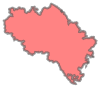

In [29]:
perimeter_data.loc[5]['geometry']

863

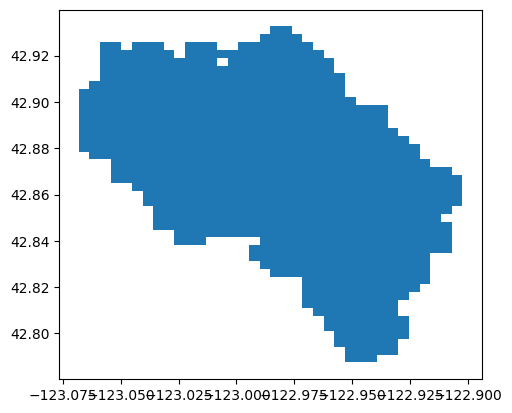

In [31]:
count_rectangles_within(perimeter_data.loc[5]['geometry'], RESOLUTION, RESOLUTION, True)

In [46]:
vegetation.first().sample(ee.Geometry.Point([-123.03775288943027, 42.791248559033406]), 375).first().get("NDVI").getInfo()

7969

In [41]:
# np.array(vegetation.sampleRectangle(gee_region).get('NDVI').getInfo()).shape
vegetation.getRegion(gee_region, 1000).getInfo()

[['id', 'longitude', 'latitude', 'time', 'NDVI'],
 ['2015_08_13', -123.06470234795385, 42.791248559033406, 1439424000000, 7079],
 ['2015_08_13', -123.05571919511266, 42.791248559033406, 1439424000000, 6585],
 ['2015_08_13', -123.04673604227146, 42.791248559033406, 1439424000000, 8563],
 ['2015_08_13', -123.03775288943027, 42.791248559033406, 1439424000000, 7969],
 ['2015_08_13', -123.02876973658907, 42.791248559033406, 1439424000000, 8114],
 ['2015_08_13', -123.01978658374787, 42.791248559033406, 1439424000000, 8114],
 ['2015_08_13', -123.01080343090668, 42.791248559033406, 1439424000000, 7639],
 ['2015_08_13', -123.00182027806548, 42.791248559033406, 1439424000000, 8205],
 ['2015_08_13', -122.9928371252243, 42.791248559033406, 1439424000000, 8692],
 ['2015_08_13', -122.9838539723831, 42.791248559033406, 1439424000000, 8807],
 ['2015_08_13', -122.9748708195419, 42.791248559033406, 1439424000000, 8807],
 ['2015_08_13', -122.96588766670071, 42.791248559033406, 1439424000000, 8726],
 ['20

In [17]:
def count_rectangles_within(geometry, cell_width_meters, cell_height_meters, plot_rects=False):
    km_per_degree = 111.1 # oversimplified conversion from degrees to km
    avg_latitude = geometry.centroid.y
    cell_width_deg = cell_width_meters / (km_per_degree * 1000 * abs(np.cos(np.radians(avg_latitude))))
    cell_height_deg = cell_height_meters / (km_per_degree * 1000)
    
    minx, miny, maxx, maxy = geometry.bounds
    
    # generate grid of rectangles within the bounding box, cound how many
    # are contained within the geometry
    # NOTE: plot_rects is for visualizing along with count, not for efficiency
    #      (it's much slower)
    if plot_rects:
        rects = []
        x = minx
        while x < maxx:
            y = miny
            while y < maxy:
                rects.append(box(x, y, x + cell_width_deg, y + cell_height_deg))
                y += cell_height_deg
            x += cell_width_deg
        
        count = sum(1 for rect in rects if geometry.intersects(rect))
        gpd.GeoSeries([rect for rect in rects if geometry.intersects(rect)]).plot()
    else:
        count = 0
        x = minx
        while x < maxx:
            y = miny
            while y < maxy:
                rect = box(x, y, x + cell_width_deg, y + cell_height_deg)
                if geometry.intersects(rect):  # using intersects for efficiency
                    count += 1
                y += cell_height_deg
            x += cell_width_deg
    
    return count

<Axes: >

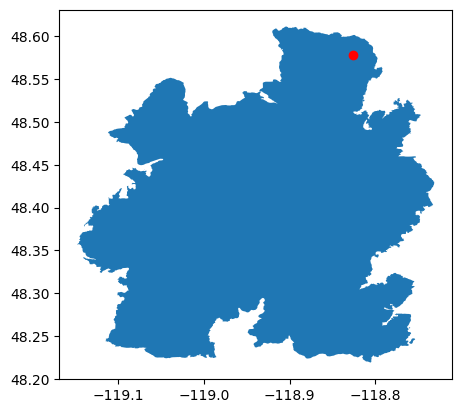

In [88]:
# Take an arbitrary VIIRS observation
data_point = filtered_viirs_data.iloc[30000]
bounding_perimeter = gpd.GeoDataFrame(geometry=[perimeter_data.loc[data_point['index_right']]['geometry']])
base = bounding_perimeter.plot()
gpd.GeoDataFrame(geometry=[data_point['geometry']]).plot(ax=base, color='red')


In [49]:
for key in unique_fire_to_perimeter.keys():
    print(key)

2015-
2015-AKAKS-504398
2015-AKCGF-000163
2015-AKCGF-CGF-000306
2015-AKCGF-CGF-000312
2015-AKCRS-514085
2015-AKCRS-514365
2015-AKCRS-514418
2015-AKCRS-514616
2015-AKCRS-514625
2015-AKDAS-512220
2015-AKDAS-512313
2015-AKDAS-512321
2015-AKDAS-512386
2015-AKDAS-512396
2015-AKFAS-511134
2015-AKFAS-511136
2015-AKFAS-511145
2015-AKFAS-511173
2015-AKFAS-511406
2015-AKFAS-511408
2015-AKFAS-511414
2015-AKFAS-511439
2015-AKFAS-511515
2015-AKFAS-511524
2015-AKFAS-511531
2015-AKFAS-511538
2015-AKFAS-511588
2015-AKFAS-511613
2015-AKGAD-000249
2015-AKGAD-000340
2015-AKGAD-000351
2015-AKGAD-000359
2015-AKGAD-000361
2015-AKGAD-000362
2015-AKGAD-000374
2015-AKGAD-000384
2015-AKGAD-000389
2015-AKGAD-000392
2015-AKGAD-000397
2015-AKGAD-000400
2015-AKGAD-000401
2015-AKGAD-000402
2015-AKGAD-000404
2015-AKGAD-000405
2015-AKGAD-000419
2015-AKGAD-000423
2015-AKGAD-000429
2015-AKGAD-000432
2015-AKGAD-000436
2015-AKGAD-000437
2015-AKGAD-000451
2015-AKGAD-000458
2015-AKGAD-000464
2015-AKGAD-000471
2015-AKGAD-000

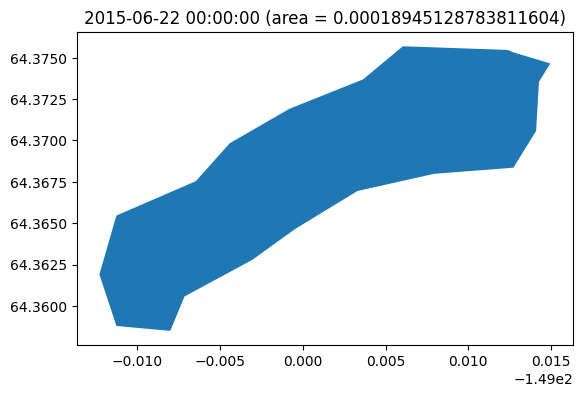

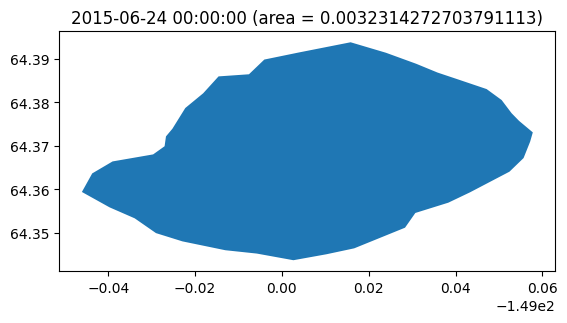

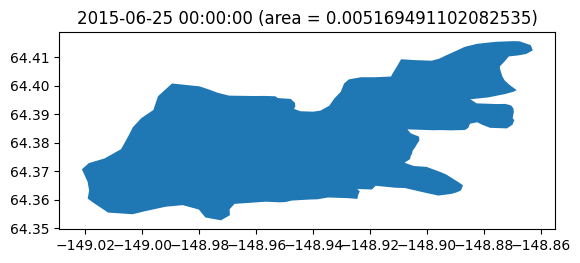

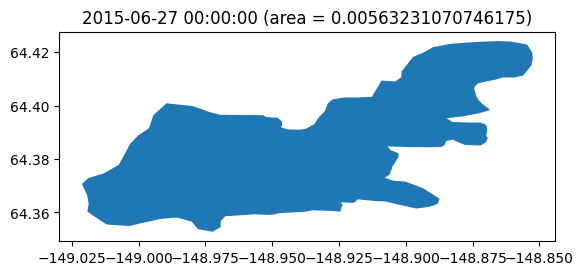

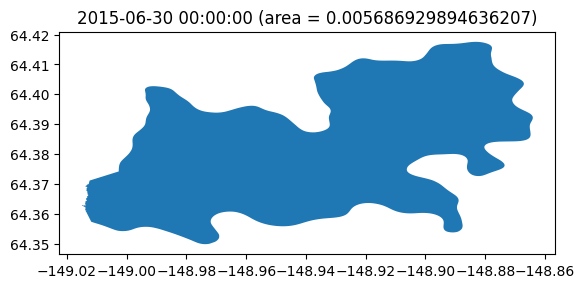

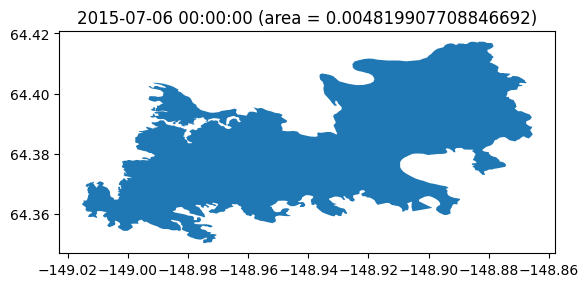

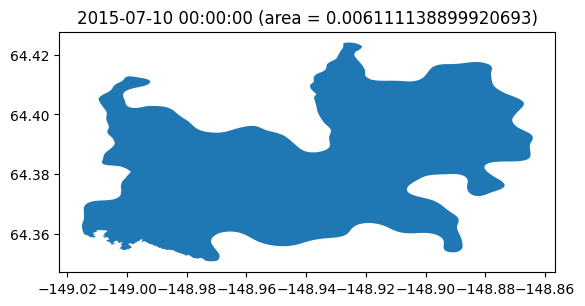

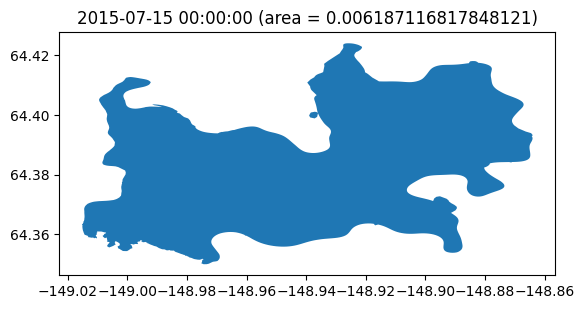

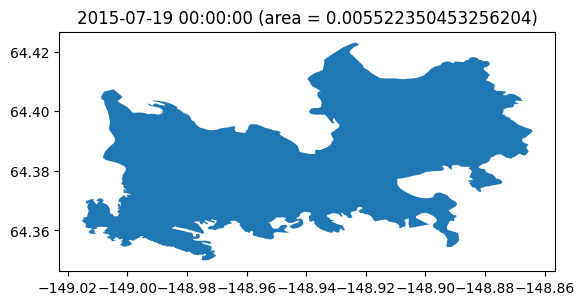

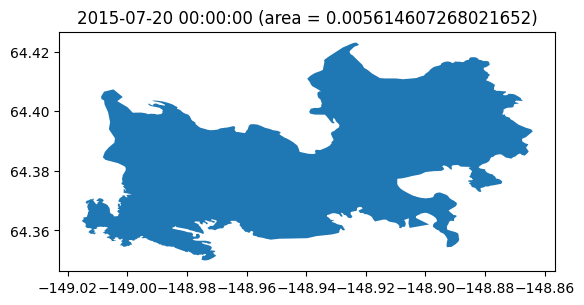

In [60]:
# new_df = gpd.GeoDataFrame(geometry=unique_fire_to_perimeter['2015-AKCGF-CGF-000306'])
# print(new_df.geometry.total_bounds)
# new_df.plot()

single_fire = perimeter_data[perimeter_data['uniquefire'] == '2015-AKFAS-511414']

for date, perimeter in sorted(zip(single_fire['datecurren'], single_fire['geometry']), key=lambda x: x[0]):
    fig = gpd.GeoDataFrame(geometry=[perimeter]).plot()
    fig.set_title(f"{date} (area = {perimeter.area})")